<a href="https://colab.research.google.com/github/phumipatc/CU_Submissions/blob/master/AI/Sound_to_Dementia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset: DementiaBank**
https://dementia.talkbank.org/


English Pitt Corpus: Cookie theft task
* https://dementia.talkbank.org/access/English/Pitt.html
* Dementia vs control



Preparing environment

In [ ]:
%pip install openl3

In [ ]:
# need to be run

def tryImportColab():
  try:
    import google.colab
    return True
  except ImportError:
    return False

runningInColab = tryImportColab()
runningInColab

In [ ]:
if(runningInColab):
  from google.colab import drive
  drive.mount('/content/drive')

# **Audio Embedding**
# OpenL3
* https://openl3.readthedocs.io/en/latest/tutorial.html
* http://www.justinsalamon.com/uploads/4/3/9/4/4394963/cramer_looklistenlearnmore_icassp_2019.pdf

# AudioSet
* https://github.com/tensorflow/models/tree/master/research/audioset
* Use vggish
* Or, https://tfhub.dev/google/vggish/1

# Other embedding models
* https://tfhub.dev/s?module-type=audio-embedding


In [ ]:
%pwd

In [ ]:
# need to be run

import pandas as pd

address_sample_csv_path = '/kaggle/input/sounddementia-data/sound-dementia-data/ADReSS-M-train/'
if runningInColab:
	address_sample_csv_path = 'drive/MyDrive/' + address_sample_csv_path

# Get dataFrame
address_sample_original_df = pd.read_csv(address_sample_csv_path + "training-groundtruth.csv")
address_sample_clean_df = address_sample_original_df
del address_sample_original_df
#address_sample_clean_df = address_sample_original_df.dropna().drop_duplicates()

# Cleaning Process
## In gender col, change "Female" to 0 and "Male" to 1
address_sample_clean_df['gender'] = address_sample_clean_df['gender'].apply(lambda x: 0 if x == "Female" else 1)
## In dx column, change "Control" to 0 and "ProbableAD" to 1
address_sample_clean_df['dx'] = address_sample_clean_df['dx'].apply(lambda x: 0 if x == "Control" else 1)

address_sample_clean_df.head()


In [ ]:
# need to be run

import os


address_sample_path = '/kaggle/input/sounddementia-data/sound-dementia-data/ADReSS-M-train/train/'
if runningInColab:
  address_sample_path = 'drive/MyDrive/' + address_sample_path
address_sample_list = []
address_sample_name = []
for fName in os.listdir(address_sample_path):
#   check if fName is file
  if os.path.isfile(os.path.join(address_sample_path, fName)):
    address_sample_name.append(fName)
    address_sample_list.append(address_sample_path + fName)
# print size of list
address_sample_name.sort()
address_sample_list.sort()
print(len(address_sample_list))
print(address_sample_name)

Before embedded audio, each audio file need to be at the same length. We are going to pad the audio file

In [ ]:
import numpy as np
# padding the audio file
def pad_audio(audio, sr, duration):
	padding_samples = int(duration*sr) - len(audio)
	if padding_samples <= 0:
		return audio
	else:
		return np.pad(audio, (0, padding_samples), 'constant')

In [ ]:
import soundfile as sf

min_duration = 1e9
max_duration = 0
for sample in address_sample_list[:]:
  audio, sr = sf.read(sample)
  min_duration = min(min_duration, len(audio) / sr)
  max_duration = max(max_duration, len(audio) / sr)
print(min_duration, max_duration)

In [ ]:
!pwd

In [ ]:
import pickle
import openl3
import gc

for i in range(191,237):
  print(str(i) + ': processing ' + address_sample_name[i])
  sample = address_sample_list[i]
  audio, sr = sf.read(sample)
  if len(audio.shape) > 1:
    audio = audio.mean(axis=1)
  audio = pad_audio(audio, sr, max_duration)
  try:
    embedding, timestamps = openl3.get_audio_embedding(audio, sr)
    try:
      with open(address_sample_name[i].split('.')[0] + '.pkl' , 'wb') as f:
        pickle.dump((embedding, timestamps), f)
        del f
    except Exception as error:
      print('error saving pickle file for ' + address_sample_name[i])
      print(error)
      break
    del embedding
    del timestamps
# save each embedding and timestamp to a file using pickle
  except Exception as error:
    print('error getting audio embedding from' + address_sample_name[i])
    print(error)
    break
  del sample
  del audio
  del sr
  gc.collect()

In [ ]:
# optional For Kaggle
import pickle
import openl3

result = []
for i in range(237):
  print('processing ' + address_sample_name[i])
  sample = address_sample_list[i]
  audio, sr = sf.read(sample)
  if len(audio.shape) > 1:
    audio = audio.mean(axis=1)
  audio = pad_audio(audio, sr, max_duration)
  try:
    embedding, timestamps = openl3.get_audio_embedding(audio, sr)
    result.append(embedding)
  except Exception as error:
    print('error getting audio embedding from' + address_sample_name[i])
    print(error)

# **Classification**
# Classics
* https://scikit-learn.org/stable/supervised_learning.html
* Logistic regression, Support Vector Classification, Decision Tree, Random Forest, Neural Net, AdaBoost, Naïve Bayes
* https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# Classification heads
* https://www.isca-speech.org/archive/pdfs/interspeech_2021/gauder21_interspeech.pdf
* Neural networks - Conv1D (k=1), Conv1D (k=3), Global. Average
* https://www.isca-speech.org/archive/pdfs/interspeech_2021/wang21ca_interspeech.pdf-Neural networks - Conv - Conv1D - Softmax
* Others
* https://www.tensorflow.org/tutorials/images/transfer_learning#add_a_classification_head

**Classic - Logistic Regressing**

In [ ]:
!ls

In [1]:
# need to be run

import pandas as pd

address_sample_csv_path = '/kaggle/input/sounddementia-data/sound-dementia-data/ADReSS-M-train/'

# Get dataFrame
address_sample_original_df = pd.read_csv(address_sample_csv_path + "training-groundtruth.csv")
address_sample_clean_df = address_sample_original_df
del address_sample_original_df
#address_sample_clean_df = address_sample_original_df.dropna().drop_duplicates()

# Cleaning Process

## Drop other columns
address_sample_clean_df.drop(['age', 'gender', 'educ', 'mmse'], axis=1, inplace=True)

## In dx column, change "Control" to 0 and "ProbableAD" to 1
address_sample_clean_df['dx'] = address_sample_clean_df['dx'].apply(lambda x: 0 if x == "Control" else 1)

address_sample_clean_df.head()


,adressfname,dx
0,adrso002,0
1,adrso003,0
2,adrso004,0
3,adrso005,0
4,adrso006,0


In [2]:
# need to be run

import os

address_sample_path = '/kaggle/input/sounddementia-data/sound-dementia-data/ADReSS-M-train/train/'
address_sample_name = []
for fName in os.listdir(address_sample_path):
#   check if fName is file
  if os.path.isfile(os.path.join(address_sample_path, fName)):
    address_sample_name.append(fName)
# print size of list
address_sample_name.sort()
print(len(address_sample_name))
# print(address_sample_name)

237


In [3]:
#need to be run for training model

import pickle
import gc

# result = np.empty((0,2681,6144), float)
result = []

address_sample_number = len(address_sample_name)
# address_sample_number = 120
#read each pickle file and append to result
for i in range(0,address_sample_number):
  print(str(i) + ': reading ' + address_sample_name[i].split('.')[0] + '.pkl')
  try:
    with open(address_sample_name[i].split('.')[0] + '.pkl', 'rb') as f:
      try:
        embedding, timestamps = pickle.load(f)
        result.append(embedding)
#        result = np.append(result, np.array(embedding))
        del embedding
        del timestamps
        gc.collect()
      except Exception as error:
        print('error loading pickle file for ' + address_sample_name[i].split('.')[0] + '.pkl')
        print(error)
  except Exception as error:
    print('error reading pickle file for ' + address_sample_name[i].split('.')[0] + '.pkl')
    print(error)

0: reading adrso002.pkl
1: reading adrso003.pkl
2: reading adrso004.pkl
3: reading adrso005.pkl
4: reading adrso006.pkl
5: reading adrso007.pkl
6: reading adrso008.pkl
7: reading adrso009.pkl
8: reading adrso010.pkl
9: reading adrso011.pkl
10: reading adrso012.pkl
11: reading adrso013.pkl
12: reading adrso014.pkl
13: reading adrso015.pkl
14: reading adrso016.pkl
15: reading adrso017.pkl
16: reading adrso018.pkl
17: reading adrso019.pkl
18: reading adrso020.pkl
19: reading adrso021.pkl
20: reading adrso022.pkl
21: reading adrso023.pkl
22: reading adrso024.pkl
23: reading adrso025.pkl
24: reading adrso027.pkl
25: reading adrso028.pkl
26: reading adrso029.pkl
27: reading adrso031.pkl
28: reading adrso032.pkl
29: reading adrso033.pkl
30: reading adrso035.pkl
31: reading adrso036.pkl
32: reading adrso037.pkl
33: reading adrso038.pkl
34: reading adrso039.pkl
35: reading adrso041.pkl
36: reading adrso042.pkl
37: reading adrso043.pkl
38: reading adrso044.pkl
39: reading adrso045.pkl
40: readin

In [4]:
del address_sample_name

In [8]:
gc.collect()

0

In [6]:
X = np.reshape(result, (np.shape(result)[0], -1))

In [16]:
for i in range(237):
    os.remove(address_sample_name[i].split('.')[0] + '.pkl')

In [9]:
# need to be run for training model

import numpy as np

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, address_sample_clean_df['dx'][:address_sample_number], test_size=0.5, random_state=42)

# X_train = np.reshape(result, (np.shape(result)[0], -1))
# y_train = address_sample_clean_df['dx'][:address_sample_number]

In [7]:
del result

In [10]:
del X

In [13]:
gc.collect()

0

In [15]:
os.remove('X_test.pkl')

In [ ]:

os.remove()

In [17]:
import pickle

pickle.dump(X_test, open('X_test.pkl','wb'))
pickle.dump(y_test, open('y_test.pkl', 'wb'))

In [18]:
pickle.dump(X_train, open('X_train.pkl', 'wb'))
pickle.dump(y_train, open('y_train.pkl', 'wb'))

In [19]:
del X_test
del y_test

In [21]:
gc.collect()

0

In [16]:
np.shape(X_train)

(150, 16472064)

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 200, random_state=0).fit(X_train, y_train)

In [23]:
# save model 
import pickle
pickle.dump(clf, open('logistic_regression_modelHalf.sav', 'wb'))

Testing

In [24]:
del X_train
del y_train

In [26]:
gc.collect()

0

In [27]:
import pickle

X_test = pickle.load(open('X_test.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))


In [ ]:
#need to be run for training model

import pickle
import gc
import numpy as np

# result = np.empty((0,2681,6144), float)
result = []

#address_sample_number = len(address_sample_name)

#read each pickle file and append to result
for i in range(address_sample_number,237):
  print(str(i) + ': reading ' + address_sample_name[i].split('.')[0] + '.pkl')
  try:
    with open(address_sample_name[i].split('.')[0] + '.pkl', 'rb') as f:
      try:
        embedding, timestamps = pickle.load(f)
        result.append(embedding)
#        result = np.append(result, np.array(embedding))
        del embedding
        del timestamps
        gc.collect()
      except Exception as error:
        print('error loading pickle file for ' + address_sample_name[i].split('.')[0] + '.pkl')
        print(error)
  except Exception as error:
    print('error reading pickle file for ' + address_sample_name[i].split('.')[0] + '.pkl')
    print(error)

In [21]:
X_test = np.reshape(result, (np.shape(result)[0], -1))
y_test = address_sample_clean_df['dx'][address_sample_number:]

In [22]:
del result

In [24]:
gc.collect()

0

In [28]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6386554621848739

Showing Confusion Matrix below

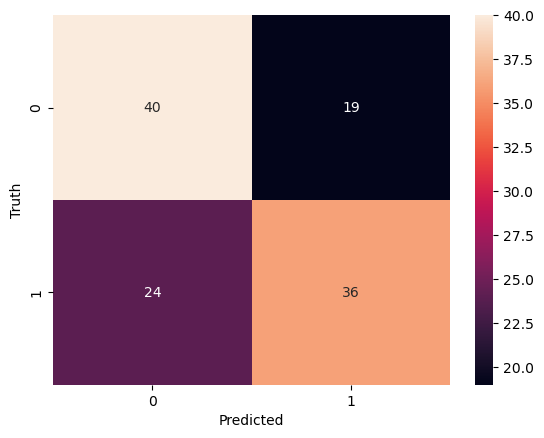

In [29]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Debug step

In [ ]:
del X
del y

In [ ]:
import pickle

clf = pickle.load(open('logistic_regression_model.sav','rb'))

In [ ]:
import pickle

result = []

# address_sample_number = len(address_sample_list)
# address_sample_number = 141
#address_sample_number = 100
# read each pickle file and append to result
for i in range(0,141):
  print('reading ' + address_sample_name[i].split('.')[0] + '.pkl')
  try:
    with open(address_sample_name[i].split('.')[0] + '.pkl', 'rb') as f:
      try:
        embedding, timestamps = pickle.load(f)
        result.append(embedding)
      except Exception as error:
        print('error loading pickle file for ' + address_sample_name[i].split('.')[0] + '.pkl')
        print(error)
  except Exception as error:
    print('error reading pickle file for ' + address_sample_name[i].split('.')[0] + '.pkl')
    print(error)

In [ ]:
import numpy as np

X = np.reshape(result, (141, -1))
y = address_sample_clean_df['dx'][:141]

del result

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X)
accuracy_score(y, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()